In [1]:
# !pip install catboost

In [2]:
from catboost import CatBoostRanker, Pool, MetricVisualizer, cv
import pandas as pd
pd.set_option('max_columns', None)
import os

# Read data

In [3]:
data_path = 'data'

In [4]:
X_train = pd.read_csv(os.path.join(data_path, 'X_train.csv'))
y_train = pd.read_csv(os.path.join(data_path, 'y_train.csv'))
groups_train = pd.read_csv(os.path.join(data_path, 'groups_train.csv'))

X_train.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,day,month,year,quarter,week,dow,doy,days_in_month,is_weekend,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,week_id,season_num,week_summer_index,day_sin,day_cos,month_sin,month_cos,quarter_sin,quarter_cos,week_sin,week_cos,dow_sin,dow_cos,doy_sin,doy_cos,season_num_sin,season_num_cos,comp1_rate_percent_diff_signed,comp2_rate_percent_diff_signed,comp3_rate_percent_diff_signed,comp4_rate_percent_diff_signed,comp5_rate_percent_diff_signed,comp6_rate_percent_diff_signed,comp7_rate_percent_diff_signed,comp8_rate_percent_diff_signed
0,1,233427,12,187,NaN,NaN,219,893,3,3.5,1,2.83,0.0438,4.95,104.77,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,4,4,2013,2,14,4,94,30,0,0,0,0,0,0,0,201314,2,11,0.724793,0.688967,0.866025,-0.5,1.224647e-16,-1.0,0.992709,-0.120537,-0.433884,-0.900969,0.999079,-0.042905,1.224647e-16,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,233427,12,187,NaN,NaN,219,88127,3,3.0,1,1.39,0.0038,4.80,138.40,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,4,4,2013,2,14,4,94,30,0,0,0,0,0,0,0,201314,2,11,0.724793,0.688967,0.866025,-0.5,1.224647e-16,-1.0,0.992709,-0.120537,-0.433884,-0.900969,0.999079,-0.042905,1.224647e-16,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,233427,12,187,NaN,NaN,219,114766,2,3.5,1,1.61,0.0052,4.67,104.77,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4,2013,2,14,4,94,30,0,0,0,0,0,0,0,201314,2,11,0.724793,0.688967,0.866025,-0.5,1.224647e-16,-1.0,0.992709,-0.120537,-0.433884,-0.900969,0.999079,-0.042905,1.224647e-16,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,233427,12,187,NaN,NaN,219,111106,3,2.5,1,0.69,0.0071,4.67,120.29,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,4,4,2013,2,14,4,94,30,0,0,0,0,0,0,0,201314,2,11,0.724793,0.688967,0.866025,-0.5,1.224647e-16,-1.0,0.992709,-0.120537,-0.433884,-0.900969,0.999079,-0.042905,1.224647e-16,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,233427,12,187,NaN,NaN,219,111000,3,4.5,1,2.20,0.0164,5.02,181.09,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,4,4,2013,2,14,4,94,30,0,0,0,0,0,0,0,201314,2,11,0.724793,0.688967,0.866025,-0.5,1.224647e-16,-1.0,0.992709,-0.120537,-0.433884,-0.900969,0.999079,-0.042905,1.224647e-16,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
CAT_FEATURES = ['srch_id',
                'site_id',
                'visitor_location_country_id',
                'prop_country_id',
                'prop_id',
                'srch_destination_id',
                'week_id', 'season_num',
                'day', 'month', 'year', 'quarter', 'week', 'dow']

# bool_cols = ['prop_brand_bool',
#              'promotion_flag',
#              'srch_saturday_night_bool',
#              'random_bool']

group_col = 'srch_id'

ranking_target = 'target'

In [7]:
train_pool = Pool(data=X_train, 
                  label=y_train,
                  group_id=groups_train,
                  cat_features=CAT_FEATURES,
                  )

In [8]:
X_val = pd.read_csv(os.path.join(data_path, 'X_val.csv'))
y_val = pd.read_csv(os.path.join(data_path, 'y_val.csv'))
groups_val = pd.read_csv(os.path.join(data_path, 'groups_val.csv'))

val_pool = Pool(data=X_val,
                label=y_val,
                group_id=groups_val,
                cat_features=CAT_FEATURES,
                )

# Cross-validation

In [ ]:
# %%time

# params = {
#     "iterations": 1000,
#     #           'loss_function': 'NDCG:top=5',
#     'loss_function': 'QueryRMSE',
#     'custom_metric': [
#         'NDCG:top=5;type=Base;denominator=LogPosition'
#         #                       , 'PFound', 'AverageGain:top=10'
#     ],
#     "verbose": False,
#     'early_stopping_rounds': 50,
#     #     'logging_level': 'Silent',
# }

# cv_results, fitted_models = cv(train_pool, params, nfold=3, type='TimeSeries', plot=True,
#                                return_models=True)

In [ ]:
# cv_results

In [ ]:
# model = fitted_models[-1]

In [ ]:
# import matplotlib.pyplot as plt

# for method in ['LossFunctionChange', 'PredictionValuesChange']:
#     fi = model.get_feature_importance(test_pool, type=method)
#     feature_score_raw = pd.DataFrame(list(zip(X_test.columns, fi)),
#                                      columns=['Feature', 'Score'])

#     feature_score = feature_score_raw.sort_values(
#         by='Score', ascending=False)

#     plt.rcParams["figure.figsize"] = (7, len(feature_score) / 4)
#     ax = feature_score.plot('Feature', 'Score', kind='barh', color='c')
#     ax.set_title("Feature Importance using {}".format(method), fontsize=14)
#     ax.set_xlabel("features")
#     ax.invert_yaxis()
#     plt.show()

In [ ]:
# model.get_all_params()

# Fit final model

In [9]:
params = {
    "iterations": 600,
    #           'loss_function': 'NDCG:top=5',
    'loss_function': 'QueryRMSE',
    'custom_metric': [
        'NDCG:top=5;type=Base;denominator=LogPosition'
        #                       , 'PFound', 'AverageGain:top=10'
    ],
    "verbose": False,
    'early_stopping_rounds': 50,
    #     'logging_level': 'Silent',
}

In [10]:
model = CatBoostRanker(**params)
model.fit(train_pool, eval_set=val_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Eval

In [11]:
X_test = pd.read_csv(os.path.join(data_path, 'X_test.csv'))
y_test = pd.read_csv(os.path.join(data_path, 'y_test.csv'))
groups_test = pd.read_csv(os.path.join(data_path, 'groups_test.csv'))

test_pool = Pool(
    data=X_test,
    label=y_test,
    group_id=groups_test,
    cat_features=CAT_FEATURES,
)

In [12]:
test_preds = model.predict(test_pool)

test_results_df = pd.DataFrame({group_col: groups_test[group_col],
                        'prop_id': X_test['prop_id'],
                        ranking_target+'_pred': test_preds,
                        ranking_target+'_gt': y_test['0'],
                         })
test_results_df.sort_values(by=[group_col, ranking_target+'_pred'],
                            ascending=[True, False], inplace=True)

test_results_df.head()

,srch_id,prop_id,target_pred,target_gt
11,299424,19005,0.250920,0
10,299424,18873,0.189371,0
8,299424,32752,0.183751,0
4,299424,440,0.152215,0
1,299424,43830,0.151795,0


In [13]:
from metrics import ndcg

print('NDCG which is used for competition evaluation')
test_results_df.groupby('srch_id')[ranking_target+'_gt'].apply(ndcg, at=5).mean()

NDCG which is used for competition evaluation


0.34981523214167837

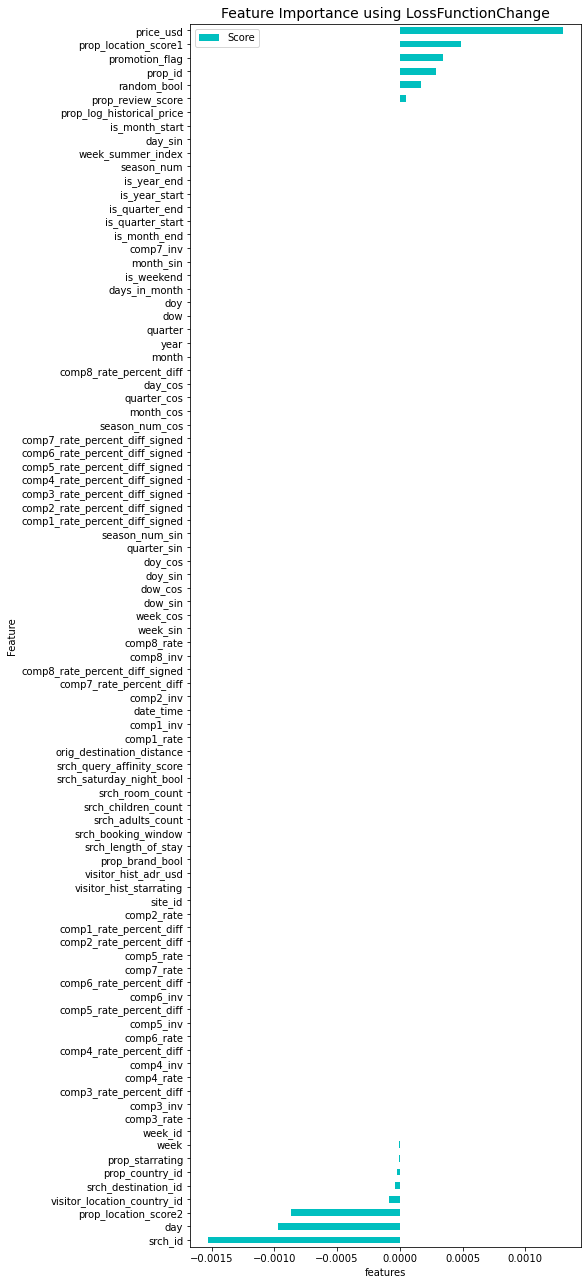

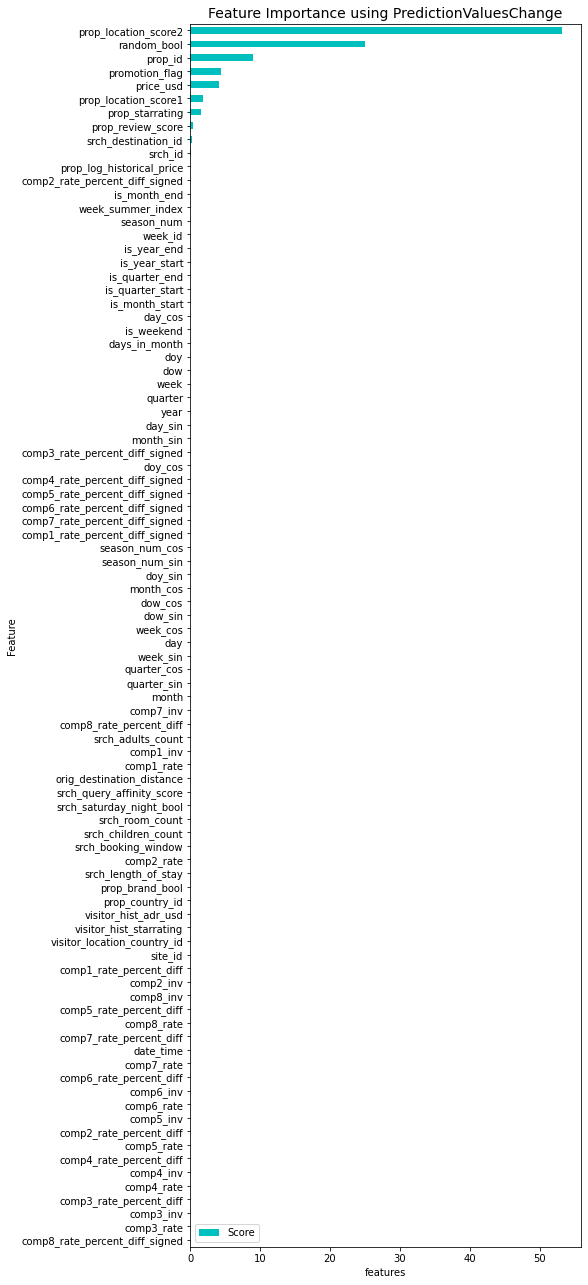

In [14]:
import matplotlib.pyplot as plt

for method in ['LossFunctionChange', 'PredictionValuesChange']:
    fi = model.get_feature_importance(test_pool, type=method)
    feature_score_raw = pd.DataFrame(list(zip(X_test.columns, fi)),
                                     columns=['Feature', 'Score'])

    feature_score = feature_score_raw.sort_values(
        by='Score', ascending=False)

    plt.rcParams["figure.figsize"] = (7, len(feature_score) / 4)
    ax = feature_score.plot('Feature', 'Score', kind='barh', color='c')
    ax.set_title("Feature Importance using {}".format(method), fontsize=14)
    ax.set_xlabel("features")
    ax.invert_yaxis()
    plt.show()

# Make preds

In [15]:
subm_df = pd.read_csv('data/submission_df_preprocessed.csv')

In [20]:
subm_pool = Pool(
    data=subm_df,
    group_id=subm_df[group_col],
    cat_features=CAT_FEATURES,
)

subm_pred = model.predict(subm_pool)

output_df = pd.DataFrame({group_col: subm_df[group_col],
                          'prop_id': subm_df['prop_id'],
                          ranking_target+'_pred': subm_pred,
                          })
output_df.sort_values(by=[group_col, ranking_target+'_pred'],
                      ascending=[True, False], inplace=True)
output_df[[group_col, 'prop_id']].to_csv('sumbission_2.csv', index=False)
output_df.head(10)

pd.read_csv('sumbission_2.csv', nrows=10)

,srch_id,prop_id
0,1,28181
1,1,54937
2,1,99484
3,1,61934
4,1,24194
5,1,82231
6,1,63894
7,1,123675
8,1,74045
9,1,34263
